In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

from src.ksd.kernel import IMQ, RBF, Linear
import src.high_dim.experiments as hd

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import matplotlib as mpl
import matplotlib.pyplot as pyplot
mpl.rcParams["mathtext.fontset"] = "cm"

In [3]:
tf.random.set_seed(1)

DELTA = 2. # 0.1

BANDWIDTH_POWER = -1. # 1.

STATISTIC = "mmd" 

KERNEL = RBF 

DIR = "../res/check"
SUFFIX = f"delta{DELTA}_r{BANDWIDTH_POWER}_{STATISTIC}_{KERNEL.__name__}"

EXTRA = "" # "_sqrt" # "_quad" #  

# Load results

In [11]:
# load analytical res
res_analytical_save = pd.read_csv(
    f"{DIR}/res_analytical_{SUFFIX}.csv",
)
res_analytical = res_analytical_save.set_index("dim", drop=False)

In [12]:
# load empirical results
# MMD high dim
stats_res_list = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}.p", "rb"),
)

dims = list(stats_res_list[0].keys())
ns = [50] * len(dims)

In [13]:
# load empirical results
# MMD low dim
stats_res_list_ld = pickle.load(
    open(f"{DIR}/stats_res_rep_{SUFFIX}_ld.p", "rb"),
)

dims_ld = list(stats_res_list_ld[0].keys())
ns_ld = [1000] * len(dims_ld)

# Initialise result classes

In [14]:
# high dim
d = dims[-2]
print("dim:", d)
ts = res_analytical.loc[d, "expectation"] * np.linspace(0., 2., 101)

hd_limits_rep_dims = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list,
    res_analytical=res_analytical,
    dims=dims,
    ns=ns,
    ts=ts,
)

dim: 1000


In [15]:
# low dim
d_ld = 2
print("dim:", d_ld)
ts_ld = res_analytical.loc[d_ld, "expectation"] * np.linspace(0.9, 1.1, 101)

hd_limits_rep_dims_ld = hd.LimitDistExperimentRepeatedMultiDims(
    empirical_vals_dims_list=stats_res_list_ld,
    res_analytical=res_analytical,
    dims=dims_ld,
    ns=ns_ld,
    ts=ts_ld,
)

dim: 2


## CDF

In [16]:
cdf_legend = {
    "probs": "Exceeding prob", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
}

In [17]:
# compute CDFs
cdf_rep = hd_limits_rep_dims.run(dim=d)

# cdf_rep.replace(cdf_legend, inplace=True)

In [18]:
# low dim
# compute CDFs
cdf_rep_ld = hd_limits_rep_dims_ld.run(dim=d_ld)

# cdf_rep_ld.replace(cdf_legend, inplace=True)

## PDF

In [19]:
pdf_legend = {
    "probs": "Dn", 
    "cond": "Classic", 
    "full": "High dim Gaussian",
    "mm_full": "High dim Gamma",
#     "mm_chi": "High dim Chi-sq",
}

In [20]:
samples_res = hd_limits_rep_dims.get_exp(d).sample_all_limits(size=1000)
# samples_res.replace(pdf_legend, inplace=True)

In [21]:
samples_res_ld = hd_limits_rep_dims_ld.get_exp(d_ld).sample_all_limits(size=1000)
# samples_res_ld.replace(pdf_legend, inplace=True)

## CDF and density plots

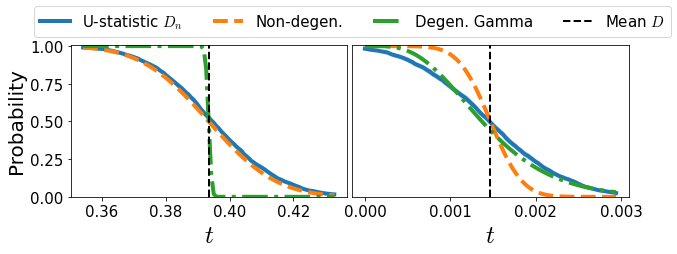

In [22]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.8))

linestyles = ["solid", "dashed", "dashdot", "dotted"]
lw = 4

# 1.ecdf plots
cdf_legends_labels = {
    "probs": r"U-statistic $D_n$",
    "cond": "Non-degen.", 
    "mm_full": "Degen. Gamma",
#     "mm_chi": "Degen. Chi-square",
}
    
# i. ksd ld
for i, (n, l) in enumerate(cdf_legends_labels.items()):
    sns.lineplot(
        ax=axes[0],
        data=cdf_rep_ld.loc[cdf_rep_ld.name == n], 
        x="ts", 
        y="value", 
        label=l,
        linestyle=linestyles[i],
        linewidth=lw,
    )

# statistic expectation
axes[0].axvline(
    res_analytical.loc[d_ld, "expectation"], color="k", linestyle="--", label=r"Mean $D$", linewidth=2,
)

axes[0].set_xlabel("$t$", fontsize=25)
axes[0].set_ylabel("Probability", fontsize=20)
axes[0].set_ylim(0., 1.01)
axes[0].tick_params(labelsize=15)
axes[0].legend([],[], frameon=False)

# ii. ksd
for i, (n, l) in enumerate(cdf_legends_labels.items()):
    sns.lineplot(
        ax=axes[1],
        data=cdf_rep.loc[cdf_rep.name == n], 
        x="ts", 
        y="value", 
        label=l,
        linestyle=linestyles[i],
        linewidth=lw,
    )
# statistic expectation
axes[1].axvline(
    res_analytical.loc[d, "expectation"], color="k", linestyle="--", label=r"Mean $D$", linewidth=2,
)

axes[1].set_xlabel("$t$", fontsize=25)
axes[1].set_ylabel("")
axes[1].set_ylim(0., 1.01)
axes[1].get_yaxis().set_visible(False)
axes[1].tick_params(labelsize=15)
# axes[1].ticklabel_format(style="sci", axis="x", scilimits=(0, 0), useMathText=True)
# axes[1].xaxis.get_offset_text().set_fontsize(15)
axes[1].legend([],[], frameon=False)
pyplot.locator_params(axis="x", nbins=4) # set no. of xticks 

axes[0].legend(
#     cdf_legends_show,
    fontsize=15, bbox_to_anchor=(2.2, 1.3), ncol=4, #columnspacing=0.7, handletextpad=0.01
)
# axes[1].legend(
# #     cdf_legends_show,
#     fontsize=15, bbox_to_anchor=(1., 1.06), 
# )

plt.subplots_adjust(
    wspace=0.02,
#     hspace=0.15,
)

# plt.savefig(f"../figs/power_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")